In [53]:
from numpy import sqrt, abs, pi, cos, sin, max, ones, array
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
from galpy.orbit import Orbit
import numpy
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
#not wrt circular rotation!
def gal_uvw(distance, lsr, ra, dec, pmra, pmdec, vrad, plx):
    '''Calculate UVW 3D Space Velocities
    Translated from IDL to Python (not by me)
    
    Follows the general outline of Johnson & Soderblom (1987, AJ, 93,864)
    except that U is positive outward toward the Galactic *anti*center, and
    the J2000 transformation matrix to Galactic coordinates is taken from
    the introduction to the Hipparcos catalog.
    
    Input:
    distance: distance (pc)
    lsr: correct output velcocities for solar motion (bool)
    ra: ra (decimal degrees)
    dec: dec (decimal degrees)
    pmra: proper motion in ra (mas/yr)
    pmdec: proper motion in dec (mas/yr)
    vrad: radial velocity (km/s)
    plx: parallax (mas; only set if no distance provided)
    
    Output
    U: Velocity (km/s) positive toward the Galactic *anti*center
    V: Velocity (km/s) positive in the direction of Galactic rotation
    W: Velocity (km/s) positive toward the North Galactic Pole
    '''
    
    import numpy

    n_params = 3

    if n_params == 0:   
        print 'Syntax - GAL_UVW, U, V, W, [/LSR, RA=, DEC=, PMRA= ,PMDEC=, VRAD='
        print '                  Distance=, PLX='
        print '         U, V, W - output Galactic space velocities (km/s)'
        return None

    if ra is None or dec is None:   
        raise Exception('ERROR - The RA, Dec (J2000) position keywords must be supplied (degrees)')
    if plx is None and distance is None:
        raise Exception('ERROR - Either a parallax or distance must be specified')
    if distance is not None:
        if numpy.any(distance==0):
            raise Exception('ERROR - All distances must be > 0')
        plx = 1e3 / distance          #Parallax in milli-arcseconds
    if plx is not None and numpy.any(plx==0):   
        raise Exception('ERROR - Parallaxes must be > 0')

    cosd = numpy.cos(numpy.deg2rad(dec))
    sind = numpy.sin(numpy.deg2rad(dec))
    cosa = numpy.cos(numpy.deg2rad(ra))
    sina = numpy.sin(numpy.deg2rad(ra))

    k = 4.74047     #Equivalent of 1 A.U/yr in km/s   
    a_g = numpy.array([[0.0548755604, +0.4941094279, -0.8676661490],
                [0.8734370902, -0.4448296300, -0.1980763734], 
                [0.4838350155, 0.7469822445, +0.4559837762]])

    vec1 = vrad
    vec2 = k * pmra / plx
    vec3 = k * pmdec / plx

    u = (a_g[0,0] * cosa * cosd + a_g[1,0] * sina * cosd + a_g[2,0] * sind) * vec1 + (-a_g[0,0] * sina + a_g[1,0] * cosa) * vec2 + (-a_g[0,0] * cosa * sind - a_g[1,0] * sina * sind + a_g[2,0] * cosd) * vec3
    v = (a_g[0,1] * cosa * cosd + a_g[1,1] * sina * cosd + a_g[2,1] * sind) * vec1 + (-a_g[0,1] * sina + a_g[1,1] * cosa) * vec2 + (-a_g[0,1] * cosa * sind - a_g[1,1] * sina * sind + a_g[2,1] * cosd) * vec3
    w = (a_g[0,2] * cosa * cosd + a_g[1,2] * sina * cosd + a_g[2,2] * sind) * vec1 + (-a_g[0,2] * sina + a_g[1,2] * cosa) * vec2 + (-a_g[0,2] * cosa * sind - a_g[1,2] * sina * sind + a_g[2,2] * cosd) * vec3

    lsr_vel = numpy.array([-10.00, 5.25, 7.17])
    if (lsr is not None):   
        u = u + lsr_vel[0]
        v = v + lsr_vel[1]
        w = w + lsr_vel[2]

    return (u,v,w)

In [101]:
c = SkyCoord(ra='19h15m11.5473s', dec='+10d56m44.704s', frame='icrs')
u_ra=-3.19
u_dec=-6.24
Vr=12.3

coo=gal_uvw(distance=8600.,lsr=True, ra=c.ra.deg, dec=c.dec.deg, pmra=u_ra, pmdec=u_dec, vrad=Vr, plx=None)
print 'Measured U, V, W (not wrt Circ rot.): ',coo[0],coo[1],coo[2], 'km/s'

Measured U, V, W:  -221.931031549 -186.725237763 3.90835895183 km/s


In [96]:
#wrt circular rotation!
def UVW(rastring,decstring,d,mu_ra,mu_dec,vlos):
    '''Calculate the peculiar velocity of a source, relative to circular motion
    at the source l and b, assuming the source to lie in the Galactic Plane

    Follows the general outline of Johnson & Soderblom (1987, AJ, 93,864), but
    use J2000 coordinates. See Dhawan et al. (2007) for details on circular motion
    transformation.

    Input:
    rastring: ra in hh:mm:ss.ss (string)
    decstring: dec in dd:mm:ss.ss (string)
    d: Source distance (kpc)
    mu_ra: Proper motion in RA (mu_alpha*cos(delta), in mas/yr)
    mu_dec: Proper motion in Dec (mu_delta, in mas/yr)
    vlos: Line of sight radial velocity (km/s)

    Output:
    U: U wrt circular motion (km/s)
    V: U wrt circular motion (km/s)
    W: W wrt circular motion (km/s)
    vpec: Peculiar velocity (km/s)

    Written by James Miller-Jones (ICRAR - Curtin).
    Requires installation of astropy and galpy'''
    
    c = SkyCoord(rastring, decstring, frame='icrs')
    # Set up the measured orbit [RA (degree), Dec (degree), d (kpc), mu_RA (mas/yr), mu_Dec (mas/yr), v_radial (km/s)]
    o=Orbit(vxvv=[c.ra.degree,c.dec.degree,d,mu_ra,mu_dec,vlos],radec=True,solarmotion='dehnen',ro=8.,vo=220.)
    '''Measured U, V, W: o.U(0.),o.V(0.),o.W(0.)
    Galactocentric radius, azimuth z: o.R(0.),o.phi(0.),o.z(0.)
    Galactic longitude, latitude: o.ll(0.),o.bb(0.)'''
    # Initialise a second orbit with same Galactocentric radius (R) and azimuth (phi) as true object,
    #but zero z, vz, vR, and vT equal to expected transverse velocity at that radius.
    #This should have circular rotation at the expected rotation curve velocity
    '''Expected U,V,W for circular rotation, U,V,W=o2.U(0.),o2.V(0.),o2.W(0.)'''
    o2=Orbit(vxvv=[o.R(0.)/8.,0.,1.,0.,0.,o.phi(0.)]) 
    # Calculate the expected peculiar velocity as the difference between the two, as in Dhawan et al. (2007)
    vpec = math.sqrt(pow((o.U(0.)-o2.U(0.)),2)+pow((o.V(0.)-o2.V(0.)),2)+pow(o.W(0.),2))
    return(o.U(0.)-o2.U(0.),o.V(0.)-o2.V(0.),o.W(0.),vpec)
def confidenceInterval(y,sig):
    median=np.mean(y)
    pct15=np.percentile(y,15)
    pct85=np.percentile(y,85)
    list1=np.array([median,median-pct15,pct85-median])
    return list1

In [106]:
ra='19h15m11.5473s'
dec='+10d56m44.704s'
mu_ra=[-3.19,0.07]
mu_dec=[-6.24,0.09]
vlos=[12.3,1.]
d=[7.,1.6,2.]
u,v,w,vp=UVW(ra,dec,d[0],mu_ra[0],mu_dec[0],vlos[0])
print 'Peculiar velocity: %6.4f km/s ' % vp
print 'Measured U, V, W wrt Circ. Rot.: ',u[0],v[0],w[0], 'km/s'

Peculiar velocity: 46.5539 km/s 
Measured U, V, W wrt Circ. Rot.:  -2.89406651373 -46.387474075 -2.66357428743 km/s


In [84]:
# mc errors
import numpy as np
ra='19h15m11.5473s'
dec='+10d56m44.704s'
mu_ra=[-3.19,0.07]
mu_dec=[-6.24,0.09]
vlos=[12.3,1.]
d=[8.6,1.6,2.]
nsim=1000
samplesD=np.random.normal(0,1,nsim)
samplesmur=np.random.normal(0,1,nsim)
samplesmud=np.random.normal(0,1,nsim)
samplesv=np.random.normal(0,1,nsim)
UU=[]
VV=[]
WW=[]
vel=[]
for ii in range(0,len(samplesD)):
    if samplesD[ii]<0.:
        D_sim = samplesD[ii]*d[1]+d[0]
    elif samplesD[ii]>0.:
        D_sim = samplesD[ii]*d[2]+d[0]
    v_sim = samplesv[ii]*vlos[1]+vlos[0]
    mur_sim = samplesmur[ii]*mu_ra[1]+mu_ra[0]
    mud_sim = samplesmud[ii]*mu_dec[1]+mu_dec[0]
    u,v,w,vp=UVW(ra,dec,D_sim,mur_sim,mud_sim,v_sim)
    UU.append(u[0])
    VV.append(v[0])
    WW.append(w[0])
    vel.append(vp)
print confidenceInterval(vel,1.)
print confidenceInterval(UU,1.)
print confidenceInterval(VV,1.)
print confidenceInterval(WW,1.)

[ 51.20562326  13.17518128  12.25498786]
[ 23.97639053  25.9996475   30.82160988]
[-38.18096694   8.85717384   7.83369226]
[-3.4018868   3.29198487  3.15351936]


(array([  15.,   78.,  221.,  202.,  143.,   81.,   75.,   29.,   28.,
          15.,    7.,   21.,   17.,   12.,   12.,    7.,    3.,    4.,
           7.,    4.,    5.,    2.,    0.,    0.,    1.,    3.,    1.,
           2.,    1.,    1.,    1.,    0.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    1.]),
 array([  27.9899969 ,   32.33996955,   36.68994221,   41.03991486,
          45.38988752,   49.73986017,   54.08983283,   58.43980548,
          62.78977814,   67.13975079,   71.48972345,   75.8396961 ,
          80.18966876,   84.53964141,   88.88961407,   93.23958672,
          97.58955938,  101.93953203,  106.28950469,  110.63947734,
         114.98945   ,  119.33942265,  123.68939531,  128.03936796,
         132.38934062,  136.73931327,  141.08928593,  145.43925858,
         149.78923124,  154.13920389,  158.48917654,  162.8391492 ,
         167.18912185,  171.53909451,  175.88906716,  180.23903982,
         184.58901247,  188.93898513,  193.28895778,  197.63893044

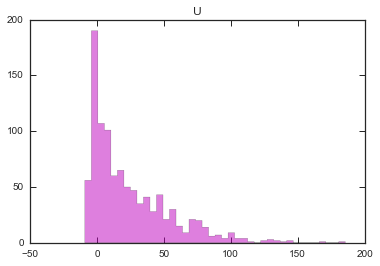

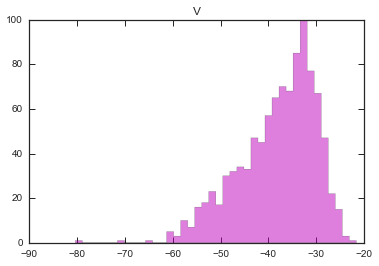

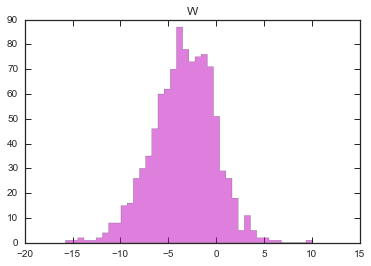

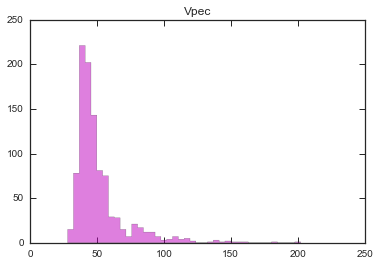

In [102]:
plt.figure()
plt.title('U')
plt.hist(UU,bins=40,alpha=0.5,color='m',histtype='stepfilled')
plt.figure()
plt.title('V')
plt.hist(VV,bins=40,alpha=0.5,color='m',histtype='stepfilled')
plt.figure()
plt.title('W')
plt.hist(WW,bins=40,alpha=0.5,color='m',histtype='stepfilled')
plt.figure()
plt.title('Vpec')
plt.hist(vel,bins=40,alpha=0.5,color='m',histtype='stepfilled')